## Config

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from punisher.common import *
from punisher.utils.dates import utc_to_epoch, epoch_to_utc
import re
from textblob import TextBlob
REDDIT_DIR = Path(cfg.DATA_DIR, 'reddit')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def plot_price(df, field, asset, ex_id):
    col_name = ohlcv_feed.get_col_name(field, asset.symbol, ex_id)
    punisher.utils.charts.plot_range(
        df, start=None, end=None, 
        column_name=col_name)

def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

def plot_price_and_tweets(df, tweet_field, price_field):
    fig, ax1 = plt.subplots(figsize=(24,18))
    ax2 = ax1.twinx()
    
    ax1.plot(df['utc'], df[price_field], color='r')
    ax1.set_xlabel('time (utc)')
    ax1.set_ylabel(price_field)
    color_y_axis(ax1, 'r')
    
    ax2.plot(df['utc'], df[tweet_field], color='blue')
    ax2.set_ylabel(tweet_field)
    color_y_axis(ax2, 'b')
    
    plt.xticks(rotation=45)
    plt.title(price_field + " vs " + tweet_field)
    ax1.grid(True)
    plt.show()
    
def get_tweet_counts(df, freq='D'):
    df = df.groupby(pd.Grouper(key='date', freq=freq)).size().to_frame()
    df['epoch'] = [utc_to_epoch(d) for d in df.index]
    df['utc'] = df.index
    df.set_index('epoch', inplace=True)
    df = df.rename(mapper={0:'tweets'}, axis='columns')
    return df

def get_tweet_sentiment(df, freq='D'):
    df = df[['date', 'sentiment']]
    df = df.groupby(pd.Grouper(key='date', freq='H')).mean()
    df['epoch'] = [utc_to_epoch(d) for d in df.index]
    df['utc'] = df.index
    df.set_index('epoch', inplace=True)
    df = df.rename(mapper={0:'sentiment'}, axis='columns')
    return df

def plot_tweets(df, freq='D'):
    # http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    tweets = get_tweet_counts(df, freq=freq)
    fig = plt.figure(figsize=(24,18))
    plt.plot(tweets['utc'], tweets['tweets'])
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title("Tweet Count")
    plt.show()

## Price

In [8]:
# https://coinmarketcap.com/api/
exchange_ids = [ex_cfg.GDAX]#, ex_cfg.BINANCE]#, ex_cfg.POLONIEX]
symbols = ['BTC/USD']#,'BTC/USDT']
assets = [Asset.from_symbol(sym) for sym in symbols]
start = datetime.datetime(year=2016, month=1, day=1)
timeframe = Timeframe.ONE_HOUR
downloaded_df = ohlcv_feed.load_multiple_assets(
    exchange_ids, assets, timeframe, start, end=None)

In [9]:
columns = ['close_BTC/USD_gdax', 'utc']#,'close_BTC/USDT_binance']
df = downloaded_df.copy()[columns]
#df = df.rename(mapper={columns[i]:exchange_ids[i] for i in range(len(columns)-1)}, axis='columns')
df.tail()

,close_BTC/USD_gdax,utc
epoch,,
1517864400,7078.34,2018-02-05 21:00:00
1517868000,6801.01,2018-02-05 22:00:00
1517871600,6905.19,2018-02-05 23:00:00
1517875200,6975.00,2018-02-06 00:00:00
1517878800,6661.54,2018-02-06 01:00:00


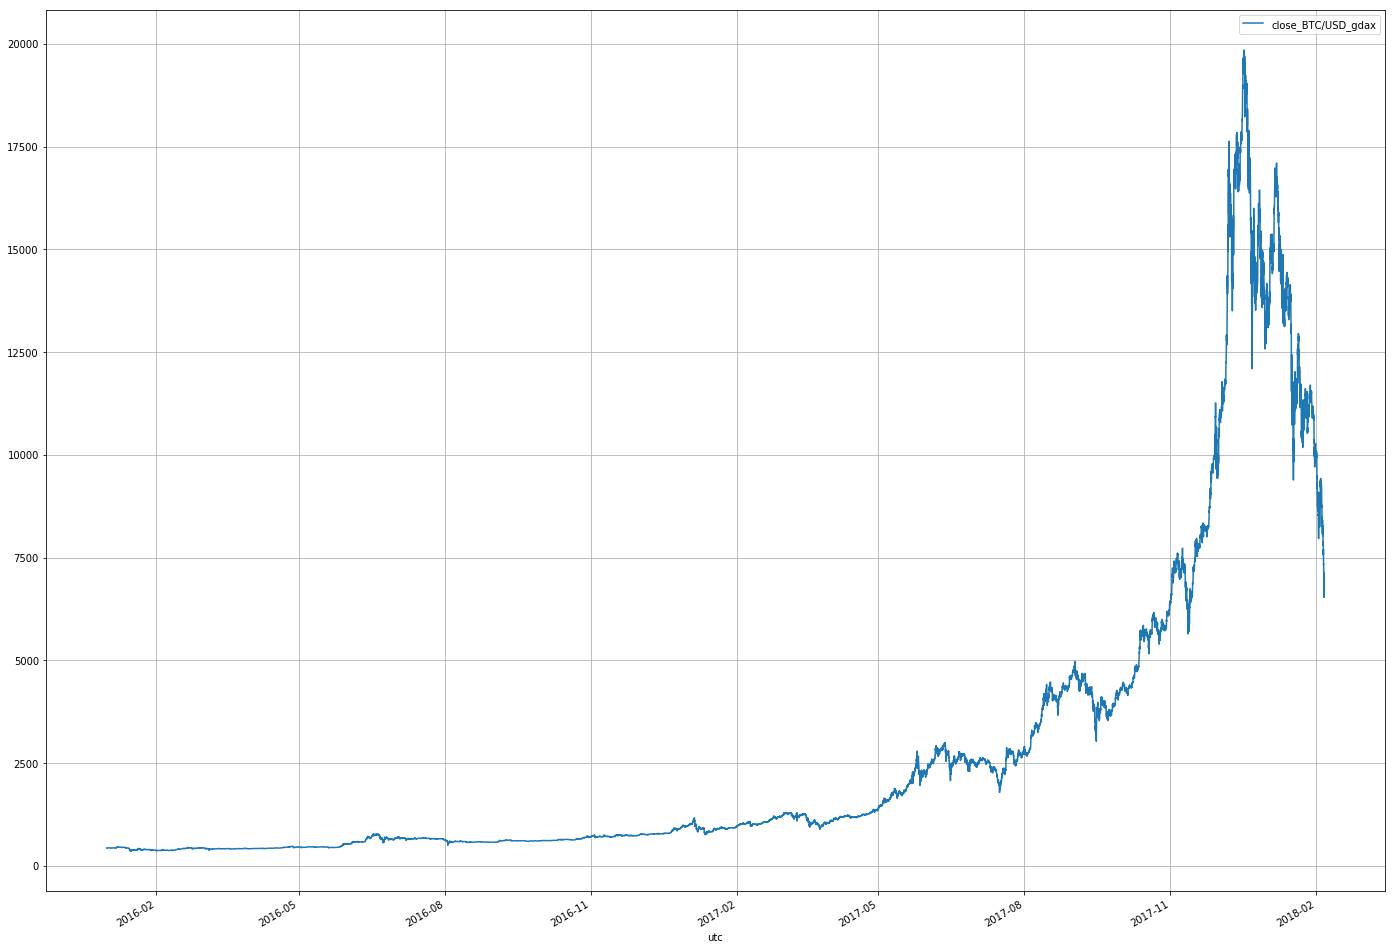

In [10]:
start = datetime.datetime(year=2016, month=1, day=1, hour=0)
end = datetime.datetime(year=2018, month=2, day=6, hour=0)
#times = [datetime(year=2018, month=2, day=1, hour=10, minute=i) for i in range(60)] + [datetime(year=2018, month=2, day=1, hour=11, minute=i) for i in range(60)]
df = df[(df['utc'] > start) & (df['utc'] < end)]
df.plot(x='utc', figsize=(24,18), grid=True)

## Submissions

In [43]:
subreddit_name = 'bitcoin'
start = datetime.datetime(year=2016, month=1, day=1, hour=0)
end = datetime.datetime(year=2016, month=1, day=2, hour=0)
top_n_comments = 10
subreddit = reddit_client.get_subreddit(subreddit_name)

In [44]:
subs = reddit_client.get_submissions(subreddit_name, start, end, top_n_comments)
subs[0]

## Sentiment

* https://github.com/abdulfatir/twitter-sentiment-analysis
* http://textblob.readthedocs.io/en/dev/
* https://github.com/fnielsen/afinn
* https://github.com/anfederico/Stocktalk/blob/master/stocktalk/scripts/streaming.py
* http://www.nltk.org/
* http://textblob.readthedocs.io/en/dev/quickstart.html#translation-and-language-detection
* https://github.com/juvaroka/tweetwise

In [70]:
def clean_body(text):
    text = re.sub("[0-9]+", "number", text)
    text = re.sub("#", "", text)
    text = re.sub("\n", "", text)
    text = re.sub("$[^\s]+", "", text)
    text = re.sub("@[^\s]+", "", text)
    text = re.sub("(http|https)://[^\s]*", "", text)
    text = re.sub("[^\s]+@[^\s]+", "", text)
    text = re.sub('[^a-z A-Z]+', '', text)
    return text

def get_sentiment(tweet):
    tweet = clean_tweet(tweet.lower())
    tweet = TextBlob(tweet)
    return tweet.polarity
    
def add_sentiment_score(tweet_df):
    tweets = tweet_df['text'].tolist()
    scores = []
    for tweet in tweets:
        score = get_sentiment(tweet)
        scores.append(score)
    tweet_df['sentiment'] = scores

In [75]:
# Load Tweets
query = 'bitcoin OR btc'
lang = 'en'
tweet_df = twitter_client.load_query_tweets_df(query, lang, start)
add_sentiment_score(tweet_df)

In [76]:
tweet_df = get_tweet_sentiment(tweet_df, freq='H')
tweet_df.head()

,sentiment,utc
epoch,,
1483228800,0.103311,2017-01-01 00:00:00
1483232400,0.116973,2017-01-01 01:00:00
1483236000,0.158845,2017-01-01 02:00:00
1483239600,0.124364,2017-01-01 03:00:00
1483243200,0.133961,2017-01-01 04:00:00


In [77]:
# Join dataframes
df = pd.concat([price_df, tweet_df[['sentiment']]], axis=1)
df.head()

,close_BTC/USD_gdax,utc,sentiment
epoch,,,
1483228800,971.00,2017-01-01 00:00:00,0.103311
1483232400,970.49,2017-01-01 01:00:00,0.116973
1483236000,967.94,2017-01-01 02:00:00,0.158845
1483239600,968.14,2017-01-01 03:00:00,0.124364
1483243200,968.10,2017-01-01 04:00:00,0.133961


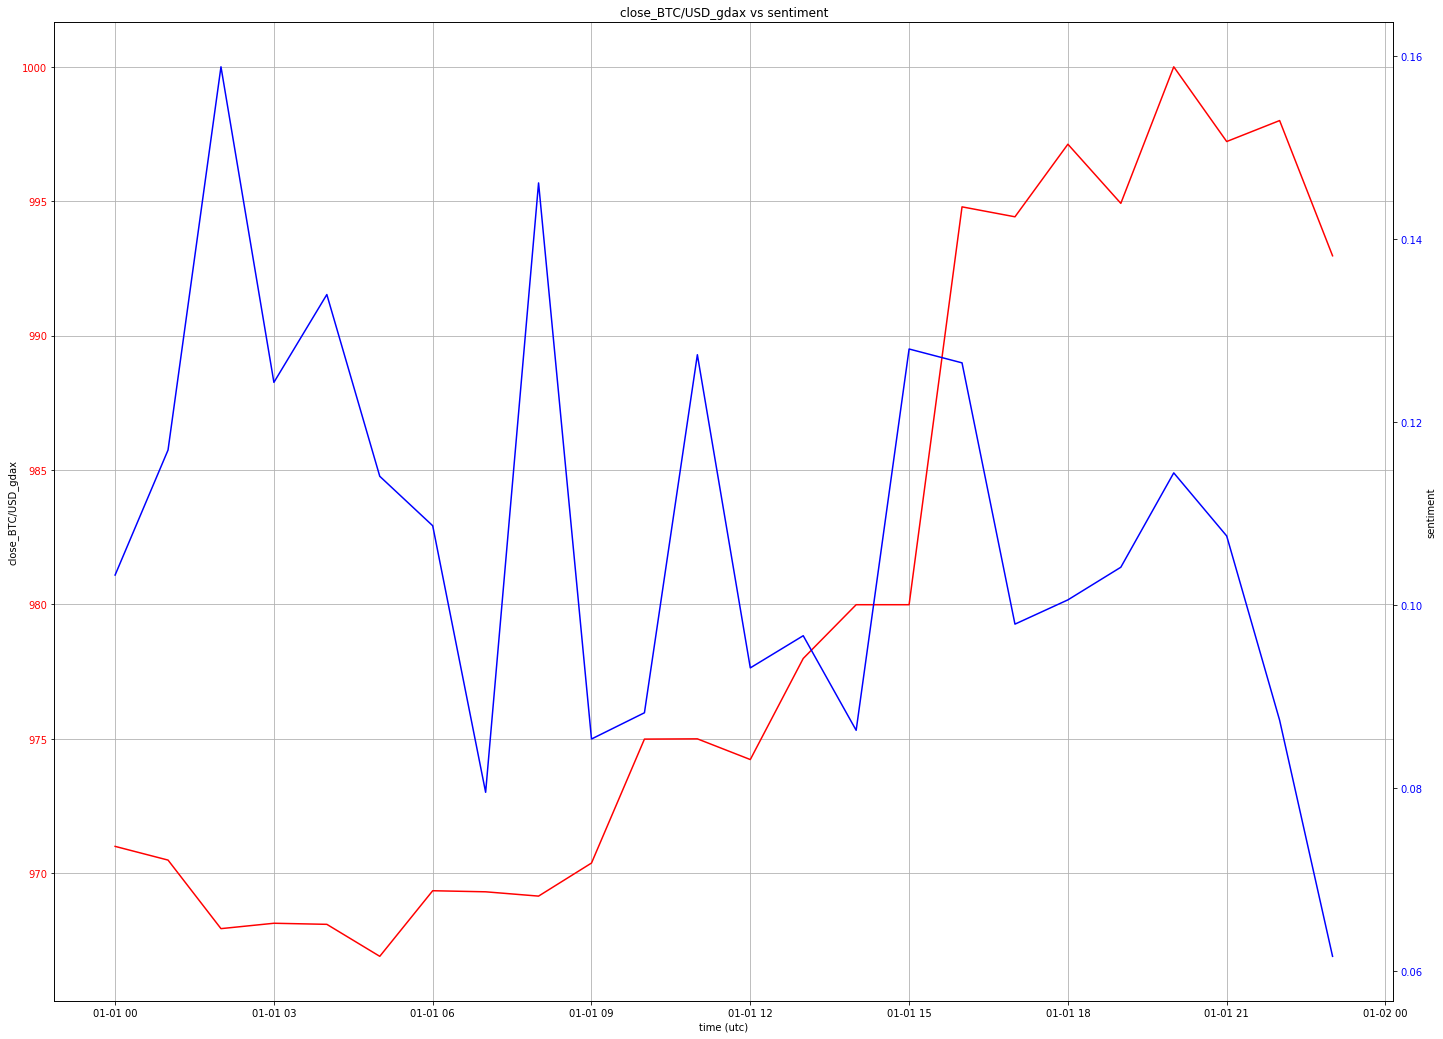

In [78]:
price_col = ohlcv_feed.get_col_name('close', assets[0].symbol, exchange_ids[0])
plot_price_and_tweets(df, tweet_field='sentiment', price_field=price_col)